**Titanic- Machine Learning from Disaster**

In [1]:
# General imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from pathlib import Path
import tarfile
import urllib.request


def load_titanic_data():
    """
    Loads the Titanic dataset from a local file or downloads it from a URL if necessary.

    Returns:
      A list containing two pandas DataFrames: train and test datasets.
    """
    tarball_path = Path("datasets/titanic.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/titanic.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as titanic_tarball:
            titanic_tarball.extractall(path="datasets")
    return [pd.read_csv(Path("datasets/titanic") / filename)
            for filename in ("train.csv", "test.csv")]

In [3]:
train_data, test_data = load_titanic_data()

# Explore the data

Let's explore the data.

In [4]:
# Showing the three first patterns in the dataset.
train_data.head(n=3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [5]:
train_data.set_index('PassengerId', inplace=True)

train_data.head(n=3)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


- **PassengerId** is the unique id of passenger
- **Survived** is the target variable we are trying to predict (0 or 1):
    - 1 = Survived
    - 0 = Not Survived
- **Pclass** (Passenger Class) is the socio-economic status of the passenger and it is a categorical ordinal feature which has 3 unique values (1, 2 or 3):
    - 1 = Upper Class
    - 2 = Middle Class
    - 3 = Lower Class
- **Name** is the name of the passenger.
- **Sex** is the sex of the passenger.
- **Age** is the age of the passenger.
- **SibSp** is the total number of the passengers' siblings and spouse.
- **Parch** is the total number of the passengers' parents and children.
- **Ticket** is the ticket number of the passenger.
- **Fare** is the passenger fare.
- **Cabin** is the cabin number of the passenger.
- **Embarked** is the port of embarkation:
    - C = Cherbourg
    - Q = Queenstown
    - S = Southampton

We notice that some features have missing values that we need to deal with. In particular the features **Age**, **Cabin** and **Embarked** have missing values. \
**Cabin** has too many missing values, so we will drop it. \
**Age** has some missing values, so we will fill them with the median age (we could replacing the missing values guessing the age from the other fields). \
**Embarked** has only 2 missing values, so we will fill them with the most common value.

Another thing to notice is that the features **Name**, **Ticket** are not useful for our model, so we will drop them.

Let's see the correlation between the features and the target variable **Survived**.

In [7]:
# Selecting the numerical attributes
train_data_num = train_data.select_dtypes(include=[np.number])
# Correlation matrix
corr_matrix = train_data_num.corr()
corr_matrix["Survived"].sort_values(ascending=False)[1:]

Fare      0.257307
Parch     0.081629
SibSp    -0.035322
Age      -0.077221
Pclass   -0.338481
Name: Survived, dtype: float64

Wee can see that the features **Fare** and **Pclass** have a high correlation with the target variable **Survived**. \
Others features like **Age**, **SibSp** and **Parch** have a low correlation with the target variable **Survived**, so we could drop them or transform them in new features.

For examples, seems that the people which travelled lonely have a lower probability to survive.

In [8]:
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]

train_data.loc[:, ["RelativesOnboard", "Survived"]
               ].groupby("RelativesOnboard").mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


As we can see people which travelled alone have a probability to survive of 30%, while people which travelled with 1 or 2 siblings/spouse have a probability to survive of 50%. The interesting thins is that people which travelled with 3 or more siblings/spouse have a probability to survive of 72%. Maybe this is because they were a children with their parents, with higher priority to be saved. 

If we bucketize the **Age** feature, we could see how different ranges of age have different probabilities to survive.

In [9]:
train_data["AgeBucket"] = train_data["Age"] // 15 * 15

train_data.loc[:, ["AgeBucket", "Survived"]].groupby("AgeBucket").mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


What emerges is that children have a higher probability to survive, while people with age between 15 and 35 have a lower probability to survive. \
All older people which ages > 70 survived.
It could be interest to compute how many people which survived have age > 70. 

In [10]:
# It could be interest to compute how many people which survived have age > 70
survived_70 = train_data.loc[(train_data["Survived"] == 1) & (
    train_data["Age"] > 70), "Survived"].count()

survived_70

1

Ok, the reason that all older people with age > 70 survived is that there were only one person with such age, and he survived.
We can delete this bucket because it is not useful for our model.

In [11]:
# Drop the row where the age is > 70
train_data.drop(train_data[train_data["Age"] > 70].index, inplace=True)

In [12]:
train_data.loc[:, ["AgeBucket", "Survived"]].groupby("AgeBucket").mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.285714


# Preprocessing

In [13]:
# Reload the original dataset
train_data, _ = load_titanic_data()

Once we have explored the data, we can start the preprocessing phase. What we want is to automate the process of preprocessing the data, so we can pass the raw data to the preprocessing function and get the preprocessed data.

What we want is to:

- Drop the columns **Name**, **Ticket** and **Cabin**, they are not useful for our model.
- Sum the columns **SibSp** and **Parch** in a new column **RelativeOnBoards**. Drop the columns **SibSp** and **Parch**.
- Fill the missing values of the column **Age** with the median age. Drop the older people with age > 70.
- Fill the missing values of the column **Embarked** with the most common value.
- Bucketize the column **Age** in 4 buckets: **Children**, **Young**, **Adult** and **Old**.
- Transform the **Pclass** in a categorical attribute (**First**, **Second**, **Third** class).
- Encode the categorical attributes. 

In [34]:
def relative_onboard(data):
    data['RelativeOnBoard'] = data['SibSp'] + data['Parch']
    return data


def age_bucket(data):
    data['AgeBucket'] = data['Age'] // 15 * 15
    data['AgeBucket'] = data['AgeBucket'].astype('category')
    return data


def drop_useless_features(data):
    return data.drop(columns=['Name', 'Ticket', 'Cabin'])


def drop_sibsp_parch(data):
    return data.drop(columns=['SibSp', 'Parch'])


def drop_age(data):
    return data.drop(columns=['Age'])


def drop_age_over_70(data):
    return data.drop(data[data['Age'] > 70].index)


def encode_pclass(data):
    data['Pclass'] = data['Pclass'].astype('category')
    return data

In [15]:
from sklearn.pipeline import Pipeline, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

In [16]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [41]:
num_imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()
cat_imputer = SimpleImputer(strategy="most_frequent")
encoder = OneHotEncoder()

In [42]:
# This pipeline will apply all the function necessary to get the feature we want
feature_pipeline = Pipeline([
    ('relative_onboard', FunctionTransformer(relative_onboard)),
    ('drop_sibsp_parch', FunctionTransformer(drop_sibsp_parch)),
    ('drop_age_over_70', FunctionTransformer(drop_age_over_70)),
    ('age_bucket', FunctionTransformer(age_bucket)),
    ('drop_age', FunctionTransformer(drop_age)),
    ('drop_useless_features', FunctionTransformer(drop_useless_features)),
    ('encode_pclass', FunctionTransformer(encode_pclass)),
])

In [ ]:
preprocessor = ColumnTransformer(
    [
      ('num', num_imputer, ['Fare']),
      ('cat', cat_imputer, ['Embarked']),
      ('cat2', encoder, ['
    ], remainder='passthrough')

In [43]:
df = feature_pipeline.fit_transform(train_data)

df.head(3)

,PassengerId,Survived,Pclass,Sex,Fare,Embarked,RelativeOnBoard,AgeBucket
0,1,0,3,male,7.2500,S,1,15.0
1,2,1,1,female,71.2833,C,1,30.0
2,3,1,3,female,7.9250,S,0,15.0


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 886 entries, 0 to 890
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   PassengerId      886 non-null    int64   
 1   Survived         886 non-null    int64   
 2   Pclass           886 non-null    category
 3   Sex              886 non-null    object  
 4   Fare             886 non-null    float64 
 5   Embarked         884 non-null    object  
 6   RelativeOnBoard  886 non-null    int64   
 7   AgeBucket        709 non-null    category
dtypes: category(2), float64(1), int64(3), object(2)
memory usage: 50.5+ KB


# Models Fine Tuning

Once we have defined the preprocessing function, we can start to fine tune the models. We will use the following models:

In [80]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [81]:
# Model pipeline
forest_model = Pipeline([
    ("preprocessing", preprocessing),
    ("rf", RandomForestClassifier())
])

svc_model = Pipeline([
    ("preprocessing", preprocessing),
    ("svc", SVC())
])

Fine tuning them!

In [82]:
from sklearn.model_selection import cross_val_score, GridSearchCV

In [85]:
# Parameters grid for the models
forest_p_grid = [{"rf__n_estimators": [
    100, 200, 300], "rf__max_depth": [5, 10, 15]}]
svm_p_grid = [{"svc__C": [0.1, 1, 10], "svc__gamma": [0.01, 0.1, 1, 10]}]

# Grid search for the models
forest_grid_search = GridSearchCV(
    forest_model, forest_p_grid, cv=10, scoring="accuracy")
svm_p_grid = GridSearchCV(svc_model, svm_p_grid, cv=10, scoring="accuracy")

In [ ]:
forest_model_tuned = Pipeline([
    ("preprocessing", preprocessing),
    ("rf", RandomForestClassifier(GridSearchCV.best_params_))
])

svn_model_tuned = Pipeline([
    ("preprocessing", preprocessing),
    ("svc", SVC(GridSearchCV.best_params_))
])

# Model Selection

In [123]:
def evaluate_model(model):
    scores = cross_val_score(
        model, train_data, train_data["Survived"], cv=10, scoring="accuracy")
    return pd.DataFrame(scores, columns=["Accuracy"])

In [ ]:
forest_acc = evaluate_model(forest_model)
svm_acc = evaluate_model(svc_model)

print(f"Accuracy for Random Forest: {forest_acc.mean()}")
print(f"Accuracy for SVM: {svm_acc.mean()}")

NameError: name 'forest_acc' is not defined

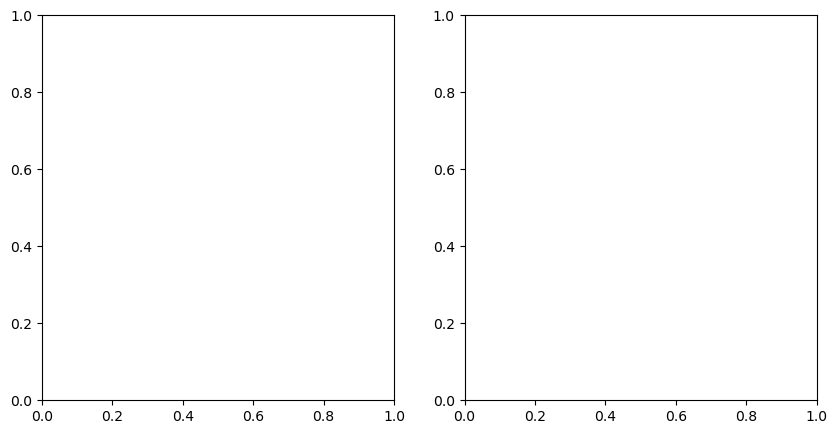

In [124]:
# I want to box plot both scores with two different diagrams side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
forest_acc.boxplot(ax=ax[0])
svm_acc.boxplot(ax=ax[1])
plt.show()

# Error analysis

In [126]:
...

Ellipsis